In [7]:
#Imports
import sys
import numpy as np              #Will be used for binning
import pandas as pd             #Will be used for data structuring
import lmfit as lf              #Fitting
import matplotlib.pyplot as plt #Basic plotting library
sys.path.append('./')
from R76Tools import *          #Tools written by me for, e.x., importing our files

#Constants
frittspath = "/data/chocula/fritts/data/k100proc/midasrq/byseries/"
neogpath = "/data/chocula/neog/rq/"
baselinecorrections = pd.read_csv("./baselinecorrectionvalues.csv")
gaus_mod = lf.Model(gaus)
gaus_params = gaus_mod.make_params()
gaus_params.add('A',min=0,value=300)
gaus_params.add('sigma',min=0,value=3,max=200)
gaus_params.add('mu',min=100,max=300,value=150)
cal_mod = lf.Model(E_cal)
cal_params = cal_mod.make_params(a=300,c=13)

In [46]:
#User-set Variables
ser = ["07220917_1039","07220917_2125","07220919_1723","07220920_0925","07220920_2052","07220921_0915"]
paths=[frittspath,frittspath,frittspath,frittspath,frittspath,frittspath]
lab = [-80.2,-80.3,-80.3,-80,-78.9,-81.1] # Actually relevant here
print((len(ser)==len(paths))and(len(paths)==len(lab)))
z=[]
#Derived variables
for i,s in enumerate(ser):
    _,z_chain = makechain(paths[i]+s+"/umn_*.root",filters=[fittingfilters,"PTOFamps0"],aliases=calibrationaliases)
    z.append(z_chain) # Do it this roundabout way to accommodate having Matt's and Himangshu's data in ser

True


In [47]:
# Fix up the names
cam=[]
for i,x in enumerate(z):
    cam.append((x['phidel']>-70)&(x['phidel']<50))
    m,b=0,0
    for j in range(len(baselinecorrections)): # Pull m and b values from the csv
        if baselinecorrections.series[j]==ser[i]:
            m=baselinecorrections.m[j]
            b=baselinecorrections.b[j]
    if ((m==0) or (b==0)):
        print("Oops! Series",ser[i],"doesn't have its correction values in the proper csv.")
    x["pt_keV_bscorr"] = x["pt_keV"]/(1+m*x["BSel"]/b)
    x["pt0_keV_bscorr"] = x["pt0_keV"]/(1+m*x["BSel"]/b)

Oops! Series 07220920_0925 doesn't have its correction values in the proper csv.
Oops! Series 07220920_2052 doesn't have its correction values in the proper csv.
Oops! Series 07220921_0915 doesn't have its correction values in the proper csv.


# Finding sigma_0:

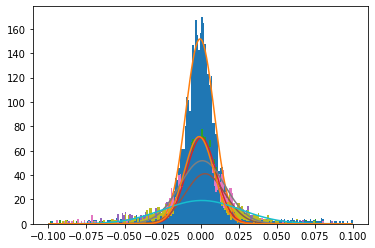

[0.009325433446549791,
 0.009712677035267347,
 0.013036782199560282,
 0.014921893498820449,
 0.025604926580435894,
 0.009638042482695841]

In [43]:
hn=[]; sigma0_values=[]
for i,x in enumerate(z):
    x["pt_keVee_root"] = 13.1849*x["pt_keV_bscorr"]/(297.667-x["pt_keV_bscorr"])
    x["pt0_keVee_root"] = 13.1849*x["pt0_keV_bscorr"]/(297.667-x["pt0_keV_bscorr"])
    hn.append(plt.hist(x["pt0_keVee_root"][x["crand"] & x["cbs"]],bins=np.linspace(-0.1,0.1,200)))
    gaus_params.add('mu',value=0,min=-0.1,max=0.1)
    bins = (hn[i][1][:-1]+hn[i][1][1:])/2
    fit_NTL = gaus_mod.fit(hn[i][0],gaus_params,x=bins)#,weights=1/np.sqrt(h4n[0]))
    sigma0_values.append(fit_NTL.params['sigma'].value)
    plt.plot(bins,fit_NTL.best_fit)
plt.show() # Ignore this plot
sigma0_values

In [44]:
for i in range(len(ser)):
    print(ser[i]+","+str(round(sigma0_values[i],4))+","+str(lab[i]))

07220910_1517,0.0093,-4.1
07220912_1955,0.0097,-66.8
07220913_0814,0.013,-66.8
07220913_1457,0.0149,97.9
07220914_1133,0.0256,97.8
07220916_2059,0.0096,-79.4


# Is there a correlation between lab voltage and sigma values?

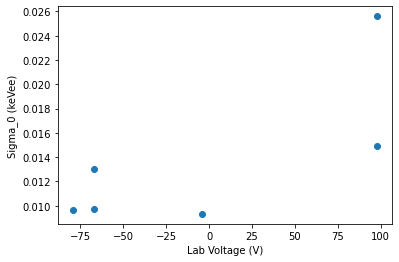

In [45]:
plt.scatter(lab,sigma0_values)
plt.xlabel("Lab Voltage (V)")
plt.ylabel("Sigma_0 (keVee)")
plt.show()

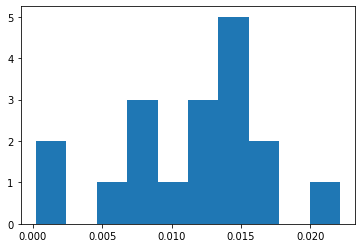

In [35]:
plt.hist(sigma0_values)
plt.show()